# Terminal Pitch Counts and Win Percentages

The core feature we are trying to assess is whether a team's hitting strategy can be modified to help improve their chances to win a game.  This notebook will be used to explore the data we have preprepared and try to find a decent model relating the terminal pitch counts to win percentage.

In the later portion of this notebook, we also introduce a defensive stat to help aid the modeling process.  Currently, this stat is simply pulled as Runs Against, but future work will be dedicated to abstracting this stat.

Once adding the Runs Against stat, one may wonder why we do not instead swap our dependent variable to Runs For.  While this would likely give a better fit, the goal of this work is to estimate how changes in hitting statistics effect win percentage in a quantitative way, not qualitative.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import os


# Set up each team's pitch count data
path_counts = '' # Path to the directory with the pitch count files
count_files = os.listdir(path_counts)
home_files = [files for files in count_files if files[4:]=='Home']
away_files = [files for files in count_files if files[4:]=='Away']

home_counts = pd.DataFrame()
away_counts = pd.DataFrame()


# Import and save home and away data separately
for file in home_files:
    cur_home = pd.read_csv(path_counts+file, index_col=[0])
    cur_home = pd.concat({file[:4]:cur_home}, names=['Year', 'Team'])
    home_counts = pd.concat([home_counts,cur_home])

for file in away_files:
    cur_away = pd.read_csv(path_counts+file, index_col=[0])
    cur_away = pd.concat({file[:4]:cur_away}, names=['Year', 'Team'])
    away_counts = pd.concat([away_counts,cur_away])


# Add W-L data for each team
path_wl = '' # Path to directory with Win/Loss team data
wl_records = os.listdir(path_wl)

home_wl = pd.DataFrame()
away_wl = pd.DataFrame()

for file in wl_records:
    year = file[-4:]
    cur_year_records = pd.read_csv(path_wl+file, index_col=[0])
    
    cur_year_home = pd.concat({year:(cur_year_records['Home_Win']/(cur_year_records['Home_Loss']+cur_year_records['Home_Win']))},
                          names=['Year', 'Team'])
    cur_year_away = pd.concat({year:(cur_year_records['Away_Win']/(cur_year_records['Away_Loss']+cur_year_records['Away_Win']))},
                          names=['Year', 'Team'])
    
    home_wl = pd.concat([home_wl, cur_year_home])
    away_wl = pd.concat([away_wl, cur_year_away])
    
home_counts_wl = pd.concat([home_counts, home_wl], axis=1).rename(columns={0:'W%'})
away_counts_wl = pd.concat([away_counts, away_wl], axis=1).rename(columns={0:'W%'})

### Check for correlations between home and away data

Currently, we are looking across 10 seasons (2000-2009) of data, corresponding to 300 different teams. As a first pass, we want to see which counts are highly correlated between home and away games.  These should represent counts where team strategy (patient vs aggressive) or individual player skill (not swinging at poor pitches and keeping at-bats alive) plays a major role.

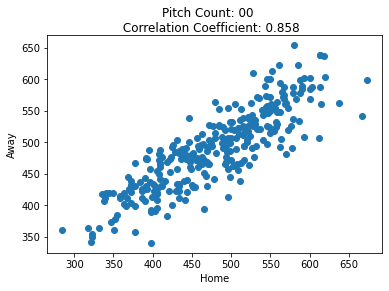

,00,10,20,30,01,11,21,31,02,12,22,32
Correlation Coefs,0.857741,0.472797,0.387397,0.593786,0.562923,0.363206,0.346481,0.631941,0.441369,0.217395,0.479388,0.725972


In [21]:
s = np.array(['0','1','2']) # Strikes
b = np.array(['0','1','2','3']) # Balls
counts = [i+j for j in s for i in b] # All possible counts

# Find correlation between home and away data for each pitch count
home_away_corr = []
for check_pitch_count in counts:
    home_away_corr.append(home_counts[check_pitch_count].corr(away_counts[check_pitch_count]))

    
# Scatter plot of highest correlation
largest_corr_pitch_count = counts[home_away_corr.index(max(home_away_corr))]
plt.scatter(home_counts[largest_corr_pitch_count],away_counts[largest_corr_pitch_count])
plt.xlabel('Home')
plt.ylabel('Away')
plt.suptitle('Pitch Count: {} \n Correlation Coefficient: {:.3f}'.format(largest_corr_pitch_count,max(home_away_corr)))
plt.show()


# Print the correlation coefficients for each pitch count
display(pd.DataFrame(home_away_corr,index=counts, columns=['Correlation Coefs']).T)

### Correlation between Home and Away Win %

Unsurprisingly, good teams generally win games, whether home or away giving a positive correlation, but the correlation is weak relative to several of the pitch count home-away correlations.  The high correlation between certain home-away pitch counts while win percentage is relatively small speaks to teams needing different home and away hitting strategies.  As a result, home and away data must be evaluated separately.

Simply looking at '00' pitch count and 'W%' is not strongly correlated.  There are also no emergent strategies for dealing with the first pitch of the at-bat giving rise to higher win percentages.  The single feature of note on home data is that having a sufficiently low '00' pitch counts resulting in end of at-bats "guarantees" a minimum win percentage.

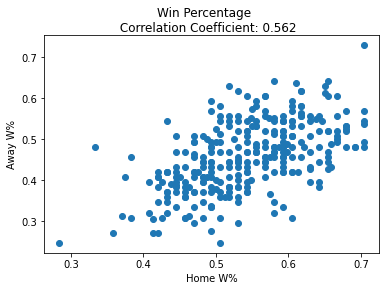

In [3]:
# Scatter plot of of home and away win percentage
plt.scatter(home_counts_wl['W%'],away_counts_wl['W%'])
plt.xlabel('Home W%')
plt.ylabel('Away W%')
plt.suptitle('Win Percentage \n Correlation Coefficient: {:.3f}'.format(home_counts_wl['W%'].corr(away_counts_wl['W%'])))
plt.show()

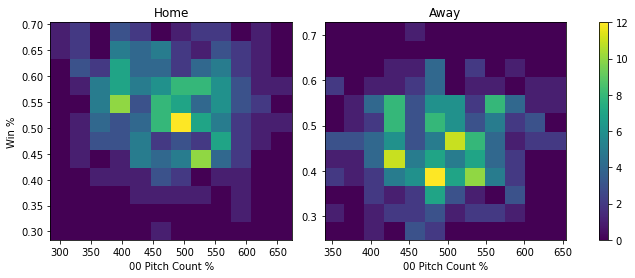

In [22]:
# Scatter plot comparing '00' pitch counts to team win %.
fig, ax = plt.subplots(1,3,figsize=(10,4),gridspec_kw=dict(width_ratios=[5,5,0.2]))
ax[0].hist2d(home_counts_wl['00'],home_counts_wl['W%'],bins=12,vmin=0,vmax=12)
ax[1].hist2d(away_counts_wl['00'],away_counts_wl['W%'],bins=12,vmin=0,vmax=12)
plt.colorbar(ax[1].collections[0],cax=ax[2])
ax[0].set_title('Home')
ax[0].set_xlabel('00 Pitch Count %')
ax[0].set_ylabel('Win %')
ax[1].set_title('Away')
ax[1].set_xlabel('00 Pitch Count %')
plt.show()

### Heatmap of correlation coefficients between different pitch counts & win percentage

Also shown is the difference between these correlation coefficients between home and away data.  Since there appears to be significant differences between home and away wins, variables that give large differences in correlation coefficients may play a significant role in these different strategies.

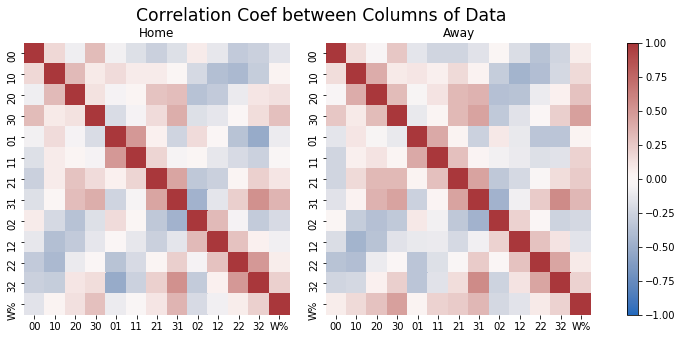

In [4]:
# Heatmap showing correlation coefficients between data for both home and away
fig, ax = plt.subplots(1,3,figsize=(11,5),gridspec_kw=dict(width_ratios=[5,5,0.2]))
sns.heatmap(home_counts_wl.corr(),ax=ax[0],cbar=False,cmap='vlag',vmin=-1.,vmax=1.)
sns.heatmap(away_counts_wl.corr(),ax=ax[1],cbar=False,cmap='vlag',vmin=-1.,vmax=1.)
plt.colorbar(ax[1].collections[0],cax=ax[2])
plt.suptitle('Correlation Coef between Columns of Data').set_size('xx-large')
ax[0].set_title('Home')
ax[1].set_title('Away')
plt.show()

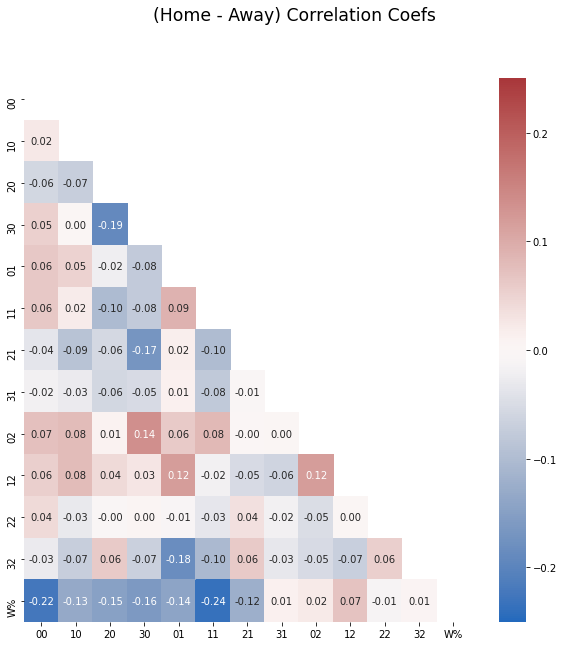

In [5]:
# Heatmap showing difference in correlation coefficients between home and away
mask = np.triu(np.ones((13,13),dtype=bool))
plt.subplots(figsize=(10,10))
sns.heatmap(home_counts_wl.corr().subtract(away_counts_wl.corr()),mask=mask,
            annot=True,fmt='.2f',cmap='vlag',vmin=-0.25,vmax=0.25)
plt.suptitle('(Home - Away) Correlation Coefs').set_size('xx-large')
plt.show()

## Principal Component Analysis

We are attempting to explain a team's win percentage using the twelve possible pitch counts, using 300 teams worth of data.  Furthermore, we want to see whether emergent strategies change over time, so we may have a desire to perform a similar analysis seasonally, with 30 teams of data.  In order to try and avoid overfitting, we will reduce the dimensionality of the problem using a Principal Component Analysis.

The Principal Component Analysis shows that there is a significant drop-off in the explained variance after the third principal component and eighty percent of the variance is captured within the first six components.  Therefore, the future analyses will be restricted to, at most, the first six principal components.

Again, this analysis will be done separately for home and away data.  When plotting the explained variance of each principal component, there is very little difference in the variance explained by each component of home and away data, so only the home data is shown.

In [6]:
# Standardize pitch count data.
# Do not transform the win percentage of each team since it is the dependent variable, which will not be used in the PCA

def StandPCA(df, cols):
    pc_col_names = ['pc'+str(i+1) for i in range(len(cols))] # List of names pc1, pc2,...
    
    df_standardized = df.copy()
    df_standardized[cols] = StandardScaler().fit_transform(df[cols]) # Standardize data
    
    # Perform a principal component analysis on all columns in consideration.
    # Save the explained variance ratio in a separate DataFrame to return for evaluation
    pca = PCA(n_components=len(cols)).fit(df_standardized[cols])
    expl_var_df = pd.DataFrame(pca.explained_variance_ratio_, columns=['EVR'], index=pc_col_names)
    expl_var_df['Cumulative'] = expl_var_df.cumsum()

    # Transform the columns considered into Principal Components
    # Columns not used in the PCA are merged after the principal components.
    df_pc = pd.DataFrame(pca.transform(df_standardized[cols]),columns=pc_col_names,index=df_standardized.index)
    df_pc = pd.concat([df_pc, df_standardized.drop(cols,axis=1)],axis=1)
    
    return [df_pc, expl_var_df]


# Standardize and PCA both home and away data
home_pc, home_evr = StandPCA(home_counts_wl, counts)
away_pc, away_evr = StandPCA(away_counts_wl, counts)

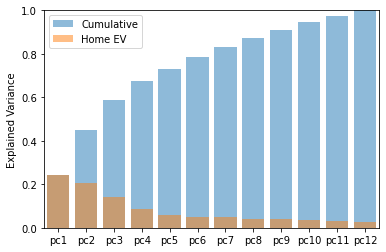

In [7]:
# Plot Explained Variance Ratio of the PCA and the cumulative sum or EVR
plt.bar(home_evr.index, home_evr['Cumulative'], alpha = 0.5, label='Cumulative')
plt.bar(home_evr.index, home_evr['EVR'], alpha = 0.5, label='Home EV')
#plt.bar(away_evr.index, away_evr['EVR'],alpha=0.5, label='Away EV')
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
plt.ylim(0,1)
plt.xlim(-0.5,11.5)
plt.ylabel('Explained Variance')
plt.show()

## Clustering Methods

First consider the possibility that multiple batting strategies could be successful within the sport.  In this scenario, different strategies (clusters of teams) would require different models to connect the hitting data to win percentages.  To account for this, we will consider clustering algorithms to separate teams into these different strategies.  In general, the number of models is variable.



### Gaussian Mixture Model

For the most part, we do not expect different strategies to be entirely distinct since each team would be a mixture of individual player tendencies, and an optimized strategy would need to cater around these tendencies.  A team would probabilistically "assigned" to a strategy depending on these behaviors.  Furthermore, this would imply that different clusters may not be separated in the high dimensional space of our data, and nearest-neighbor clusting would fail.

Applying the GMM algorithm to the data at hand, we see that there is no real advantage in choosing anymore than one cluster for both home and away data.

In [8]:
min_pc_kept = 3
max_pc_kept = 6
max_models = 10
mix_data = away_pc


# Create DataFrame of zeros for the AIC and BIC score
# Values will be saved for each combination of Principal Components retained and GMM components
zeros = np.zeros((max_pc_kept-min_pc_kept+1,max_models))
gmm_aic_score = pd.DataFrame(zeros, index=[i for i in range(min_pc_kept,max_pc_kept+1)],columns=[i for i in range(1,max_models+1)])
gmm_bic_score = gmm_aic_score.copy()

for pc_col in range(min_pc_kept,max_pc_kept+1):
    X = mix_data.drop(mix_data.columns[pc_col:11],axis=1) # Include the first N principal components and the W%

    # Fit a Gaussian Mixture Model for each possibility of 1 to max_models clusters
    # For each model, save the AIC and BIC scores
    for gmm_num in range(1,max_models+1):
        gmm = GaussianMixture(n_components=gmm_num, n_init=25).fit(X)
        gmm_aic_score.loc[pc_col, gmm_num] = gmm.aic(X)
        gmm_bic_score.loc[pc_col, gmm_num] = gmm.bic(X)

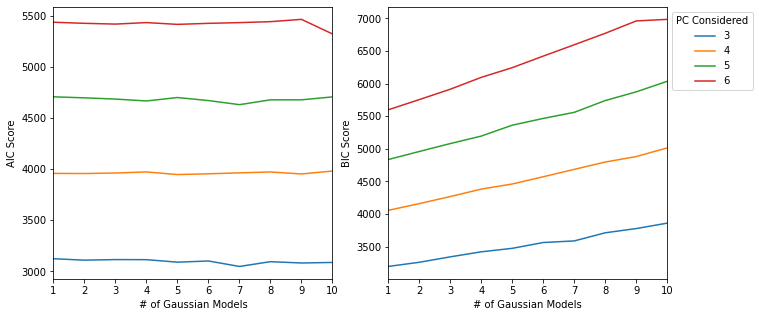

In [9]:
# Plot AIC and BIC scores for each set of principal components considered
fig, ax = plt.subplots(1,2,figsize=(11,5))
for pc_col in range(min_pc_kept, max_pc_kept+1):
    ax[0].plot(gmm_aic_score.loc[pc_col], label=str(pc_col))
    ax[1].plot(gmm_bic_score.loc[pc_col], label=str(pc_col))
plt.legend(title='PC Considered', bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
ax[0].set_xlim(1,max_models)
ax[0].set_xlabel('# of Gaussian Models')
ax[0].set_ylabel('AIC Score')
ax[1].set_xlim(1,max_models)
ax[1].set_xlabel('# of Gaussian Models')
ax[1].set_ylabel('BIC Score')
#plt.yscale('log')
plt.show()

#### Rough separation in wins

As a sanity check, we separate teams into above or below average wins. We are primarily interested in what makes up a winning team.  However, the pairwise plots show that there is little separation between the two designations of teams.

Even within the above-average winning teams, only the third principal component shows any indication of potential clustering between winning strategies.

True     156
False    144
Name: W%, dtype: int64

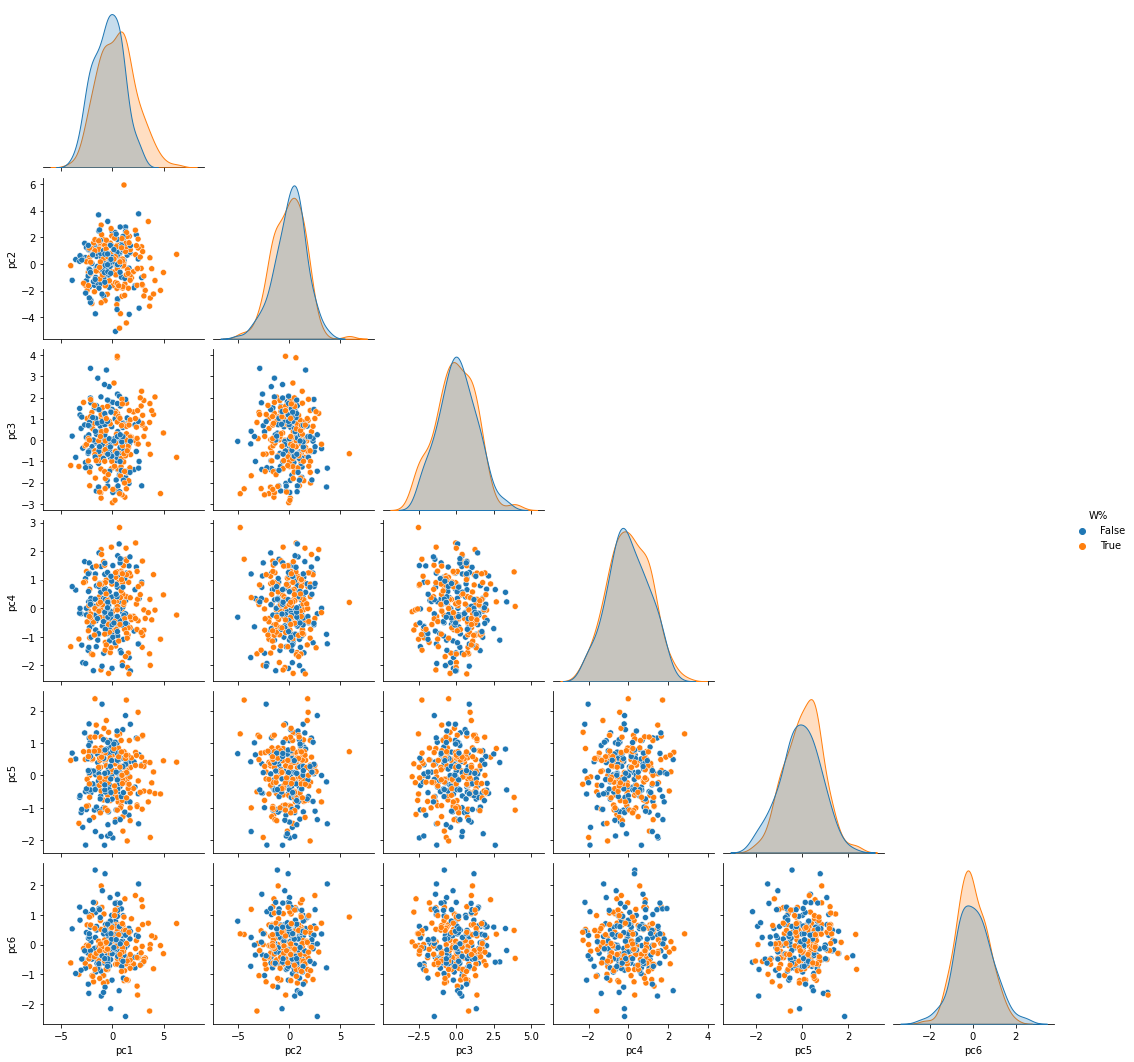

In [25]:
# List of principal components to make pairwise plot for
pcs = ['pc'+str(i+1) for i in range(6)]

# "Classify" teams whether they win above or below avg
win_separated = home_pc.copy()
win_separated['W%'] = (home_pc['W%']>home_pc['W%'].mean()) # Separate into above and below avg win teams

display(win_separated['W%'].value_counts())
sns.pairplot(win_separated,vars=pcs, hue='W%',corner=True)
plt.show()

### Agglomerative Clustering

As mostly a sanity check, we consider a nearest-neighbor clustering algorithm after standardizing the win percentage data.  Since most teams are clustered around the average number of wins, this clustering algorithm primarily splits the data along the first principal component, since it has the largest variance.  This is seen clearly using the Ward Linkage on the Agglomerative Clustering algorithm.  As a result, if this clusting was indicitive of different strategies emerging, the Gaussian Mixture Model should have separated the clusts as well.  Similarly, using an Average or Single Linkage criterion pulls out potential outliers in the data, but does not lead to any true classification.

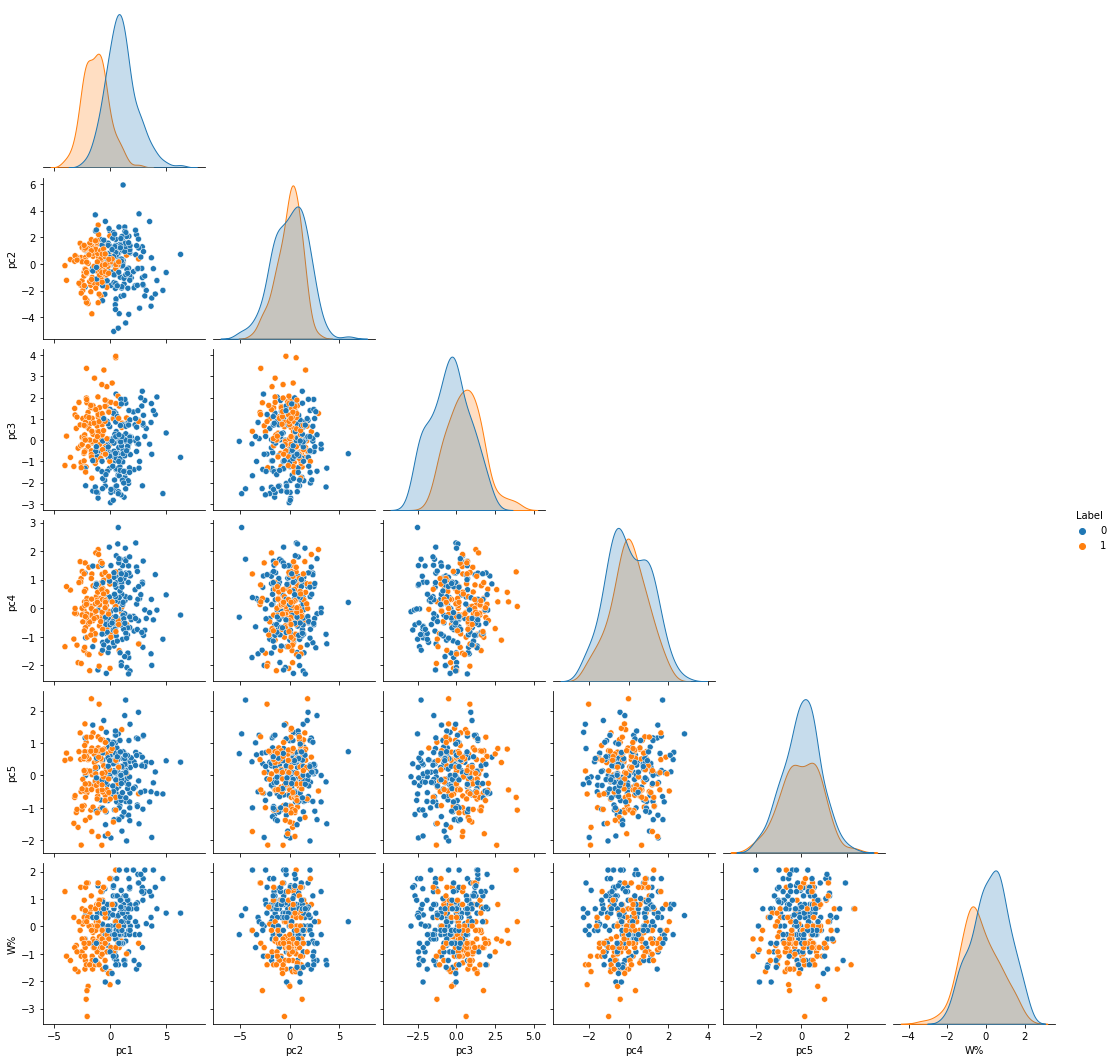

In [24]:
pc_kept = 5
num_clust = 2
mix_data = home_pc.copy()

# Standardize the W% to keep consistent distance measure
mix_data['W%'] = (mix_data['W%'] - mix_data['W%'].mean())/mix_data['W%'].std()


X = mix_data.drop(mix_data.columns[pc_kept:11],axis=1)

clustering = AgglomerativeClustering(n_clusters=num_clust,linkage='ward').fit(X)

pcs = ['pc'+str(i+1) for i in range(pc_kept)]
pcs_w_wins = pcs
pcs_w_wins.append('W%')
mix_data['Label'] = clustering.labels_
sns.pairplot(mix_data,vars=pcs_w_wins, hue='Label',corner=True)
plt.show()

## Modelling and Fitting

The previous clustering algorithms showed that all of the data should be treated equally by the same model.  Thus, we consider a model to relate the pitch counts to win percentage.  The principal components using here are simply linear combinations of standardized pitch counts.

Despite trying to model a win probability, a logistic model will not be used.  All of the win percentages are between 30% and 70%.  As a result, the data is bounded by 0.5 $\pm$ 0.2 (not to be confused with mean and standard deviation), which has Taylor expansion:

$
\log\left(\frac{W\%}{1-W\%}\right) \approx 4(W\%-0.5) + \frac{16}{3}(W\%-0.5)^3 + ...,
$

which results in non-linear terms correcting the linear approximation by less than 3%.  We can begin by looking at linear models between the first n principal components and the win percentage.

We find that this linear model does a poor job at describing the variation in win percentage, despite the error measurements falling within one standard deviation of the true win percent.  More concerning is that the model consistently overpredicts wins for poor performing teams and underpredicts for teams performing well.  As a result, all teams are pushed towards the average win percentage.

Trained R^2: 0.1424723771182752
Test R^2: 0.10968162419304028

Error Measures (Train, Test)
MAE: 0.0597,0.0615
MSE: 0.0054,0.0051
RMSE: 0.0732,0.0714
StD of W%: 0.0785


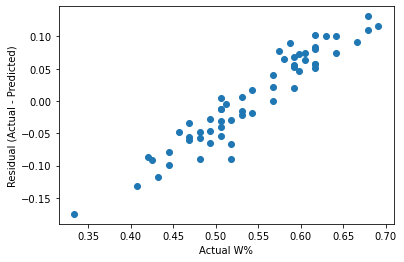

In [12]:
# Linear Regression using the first few principal components to model the team's win percentage.
pc_kept = 5
X = home_pc.iloc[:,0:pc_kept]
y = home_pc['W%']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lin_regr = LinearRegression().fit(X_train, y_train)
y_pred = lin_regr.predict(X_test)
y_pred_train = lin_regr.predict(X_train)

# Display various statistics about the regression
print('Trained R^2:',lin_regr.score(X_train,y_train))
print('Test R^2:', lin_regr.score(X_test,y_test))
print()
print('Error Measures (Train, Test)')
print('MAE: {:.4f},{:.4f}'.format(metrics.mean_absolute_error(y_train, y_pred_train),metrics.mean_absolute_error(y_test, y_pred)))
print('MSE: {:.4f},{:.4f}'.format(metrics.mean_squared_error(y_train, y_pred_train),metrics.mean_squared_error(y_test, y_pred)))
print('RMSE: {:.4f},{:.4f}'.format(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)),np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
print('StD of W%: {:.4f}'.format(home_pc['W%'].std()))


# Plot residuals
plt.scatter(y_test, y_test-y_pred)
plt.xlabel('Actual W%')
plt.ylabel('Residual (Actual - Predicted)')
plt.show()

## Model Correction

A team's batting strategy will naturally draw from a distribution to give the total runs scored.  Whereas before, these total runs scored were assumed to (linearly) relate to win probability, it ignores the distribution of the opponents runs scored, which introduces a large about of variation into the data.  The magnitude of this effect is specific for baseball, since one team's offense does not reduce the effectiveness of the other's; There is no shared resource, such as game time.

Currently, the goal is not to investigate the pitching and defensive side of baseball, so we will not provide a high level statistic for these effects.  Future work will be aimed effectively modelling the Runs Against for a team to combine with the effects of the team's batting strategy.  But for now, we will consider the Runs Allowed, both home and away, for each team.  As a result, we can use Pythagorean Win Expectation to help relate the total runs scored and runs against to the win percentage of the team.

In [13]:
# Add a defensive stat in Runs Against
path_ra = '' # Path to the directory with the teams' runs for and against data
runs_records = os.listdir(path_ra)

home_ra = pd.DataFrame()
away_ra = pd.DataFrame()

for file in runs_records:
    year = file[-4:]
    cur_year_records = pd.read_csv(path_ra+file, index_col=[0])
    
    cur_year_home = pd.concat({year:(cur_year_records['Home Runs Against'])}, names=['Year', 'Team'])
    cur_year_away = pd.concat({year:(cur_year_records['Away Runs Against'])}, names=['Year', 'Team'])
    home_ra = pd.concat([home_ra, cur_year_home])
    away_ra = pd.concat([away_ra, cur_year_away])
    
home_pc_ra = pd.concat([home_pc, home_ra], axis=1).rename(columns={0:'RA'})
away_pc_ra = pd.concat([away_pc, away_ra], axis=1).rename(columns={0:'RA'})

### Gaussian Mixture model

As before, check for different clusters of teams with the addition of the Runs Against data.

In [14]:
min_pc_kept = 3
max_pc_kept = 6
max_models = 10
mix_data = home_pc_ra


# Create DataFrame of zeros for the AIC and BIC score for each combination
# of Principal Components retained and GMM components
zeros = np.zeros((max_pc_kept-min_pc_kept+1,max_models))
gmm_aic_score = pd.DataFrame(zeros, index=[i for i in range(min_pc_kept,max_pc_kept+1)],columns=[i for i in range(1,max_models+1)])
gmm_bic_score = gmm_aic_score.copy()

for pc_col in range(min_pc_kept,max_pc_kept+1):
    # Include the first N principal components, RA, and W%
    X = mix_data.drop(mix_data.columns[pc_col:11],axis=1)

    # Fit a Gaussian Mixture Model for each possibility of 1 to max_models clusters
    # For each model, save the AIC and BIC scores
    for gmm_num in range(1,max_models+1):
        gmm = GaussianMixture(n_components=gmm_num, n_init=25).fit(X)
        gmm_aic_score.loc[pc_col, gmm_num] = gmm.aic(X)
        gmm_bic_score.loc[pc_col, gmm_num] = gmm.bic(X)

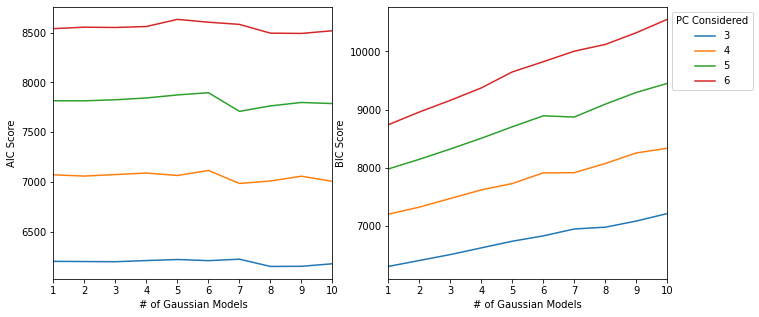

In [15]:
# Plot AIC and BIC scores for each set of principal components considered
fig, ax = plt.subplots(1,2,figsize=(11,5))
for pc_col in range(min_pc_kept, max_pc_kept+1):
    ax[0].plot(gmm_aic_score.loc[pc_col], label=str(pc_col))
    ax[1].plot(gmm_bic_score.loc[pc_col], label=str(pc_col))
plt.legend(title='PC Considered', bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
ax[0].set_xlim(1,max_models)
ax[0].set_xlabel('# of Gaussian Models')
ax[0].set_ylabel('AIC Score')
ax[1].set_xlim(1,max_models)
ax[1].set_xlabel('# of Gaussian Models')
ax[1].set_ylabel('BIC Score')
#plt.yscale('log')
plt.show()

##  Pythagorean Expectation & Linear Regression

We will be looking at a model using Pythagorean Expectation.  As stated previously, we are essentially modelling a team's runs scored by their pitch counts, and calculating a win probability additionally using their runs against.  The basic model we will consider is given explicitly as:

$
(W\%)^{-1} = 1 + \left(\frac{\text{Runs Against}}{\text{Runs For}}\right)^\gamma,
$

for some exponent $\gamma$.  Since we will be using pitch count data to try and model for Runs For, we can invert this equation as:

$
\frac{\text{Runs For}}{\text{Runs Against}} = \left(\frac{W\%}{1-W\%}\right)^{1/\gamma} \approx 1 + \frac{4}{\gamma}(W\% - 0.5) + ...
$

The "Runs For" stat will be modelled as a linear relation with the principal components previously discussed.  By multiplying the $W\%$ with Runs Against, the resulting quantity should then be linear in all principal components and Runs Against.


Note: A derivation of Pythagorean Win Expectation can be found (https://arxiv.org/abs/math/0509698) starting from a principal of sample from distributions of Runs For and Runs Against.

Trained R^2: 0.41651287034372775
Test R^2: 0.539378242603247
Error Measures (Train, Test)
MAE: 16.71, 15.41
MSE: 422.76, 358.99
RMSE: 20.56, 18.95
StD of RAxW%: 27.27


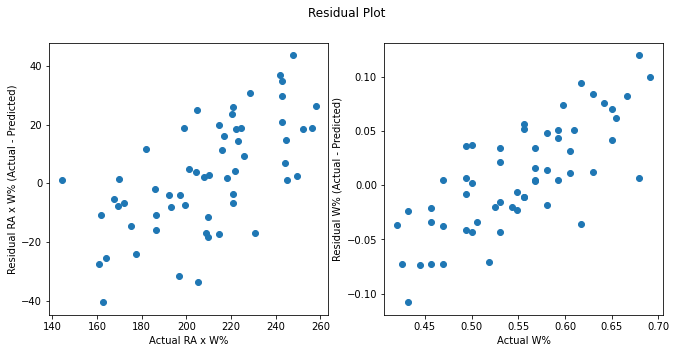

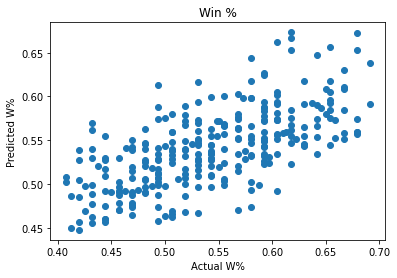

In [20]:
# Change the dependent variable from W% to RA x W%, and save this new value to the DataFrame
home_model = home_pc_ra.copy()
away_model = away_pc_ra.copy()

home_model['RAxW%'] = home_pc_ra['RA']*home_pc_ra['W%']
away_model['RAxW%'] = away_pc_ra['RA']*away_pc_ra['W%']


# Set up linear regression, again keeping only the first few principal components and Runs Against
pc_kept = 5
pcs = ['pc'+str(i+1) for i in range(pc_kept)]
pcs_model = pcs
pcs_model.append('RA')
data = home_model

# Remobe particularly large outliers in one particular stat
outlier_stat = 'W%'
X = data[pcs_model][np.abs((data[outlier_stat]-data[outlier_stat].mean())/data[outlier_stat].std())<=2]
y = data['RAxW%'][np.abs((data[outlier_stat]-data[outlier_stat].mean())/data[outlier_stat].std())<=2]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lin_regr = LinearRegression().fit(X_train, y_train)

print('Trained R^2:',lin_regr.score(X_train,y_train))
print('Test R^2:', lin_regr.score(X_test,y_test))


y_pred = lin_regr.predict(X_test)
y_pred_train = lin_regr.predict(X_train)

print('Error Measures (Train, Test)')
print('MAE: {:.2f}, {:.2f}'.format(metrics.mean_absolute_error(y_train, y_pred_train),metrics.mean_absolute_error(y_test, y_pred)))
print('MSE: {:.2f}, {:.2f}'.format(metrics.mean_squared_error(y_train, y_pred_train),metrics.mean_squared_error(y_test, y_pred)))
print('RMSE: {:.2f}, {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)),np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
print('StD of RAxW%: {:.2f}'.format(y.std()))


# Plot residuals
fig, ax = plt.subplots(1,2,figsize=(11,5))
ax[0].scatter(y_test, y_test-y_pred)
ax[0].set_xlabel('Actual RA x W%')
ax[0].set_ylabel('Residual RA x W% (Actual - Predicted)')
ax[1].scatter(y_test/X_test['RA'], (y_test-y_pred)/X_test['RA'])
ax[1].set_xlabel('Actual W%')
ax[1].set_ylabel('Residual W% (Actual - Predicted)')
plt.suptitle('Residual Plot')
plt.show()


# Plot the predicted values for the entire sample against the true wins
t = np.linspace(0,1,1000)
plt.scatter(y/X['RA'], lin_regr.predict(X)/X['RA'])
# plt.plot(t,t,'k--')
# plt.xlim(0.25, 0.75)
# plt.ylim(0.35, 0.75)
plt.xlabel('Actual W%')
plt.ylabel('Predicted W%')
plt.title('Win %')
plt.show()

## Final Words

The improvements made to the model overall greatly improved the amount of explained variance. But ultimately, adding the defensive stat was not enough to remove the linear relation of the residuals, although this tension was certainly lessened.  This dependence is likely due to a difference in the frequencies teams reach base on different pitch counts, which has thus far been ignored for the sake of dimensionality.